📂 Analizando logs en: C:\Users\benja\Desktop\QSAR\EDA

✅ ANÁLISIS COMPLETADO: 11 modelos evaluados.

🏆 --- TOP DESCRIPTORES (CONSENSO) ---
  Descriptor  Votos  Frecuencia (%)
    LOGPcons      7       63.636364
  MACCSFP125      6       54.545455
         PCR      5       45.454545
     Psi_e_A      5       45.454545
 P_VSA_ppp_D      4       36.363636
          Mp      4       36.363636
SpMin1_Bh(p)      4       36.363636
       33,50      3       27.272727
     SHED_AL      3       27.272727
SM12_AEA(ri)      3       27.272727
   P_VSA_s_3      3       27.272727
      MATS5m      3       27.272727
      piPC05      3       27.272727
      MATS5p      3       27.272727
   N_percent      2       18.181818

💾 Ranking guardado en: C:\Users\benja\Desktop\QSAR/EDA\Ranking_Final_Consenso.csv


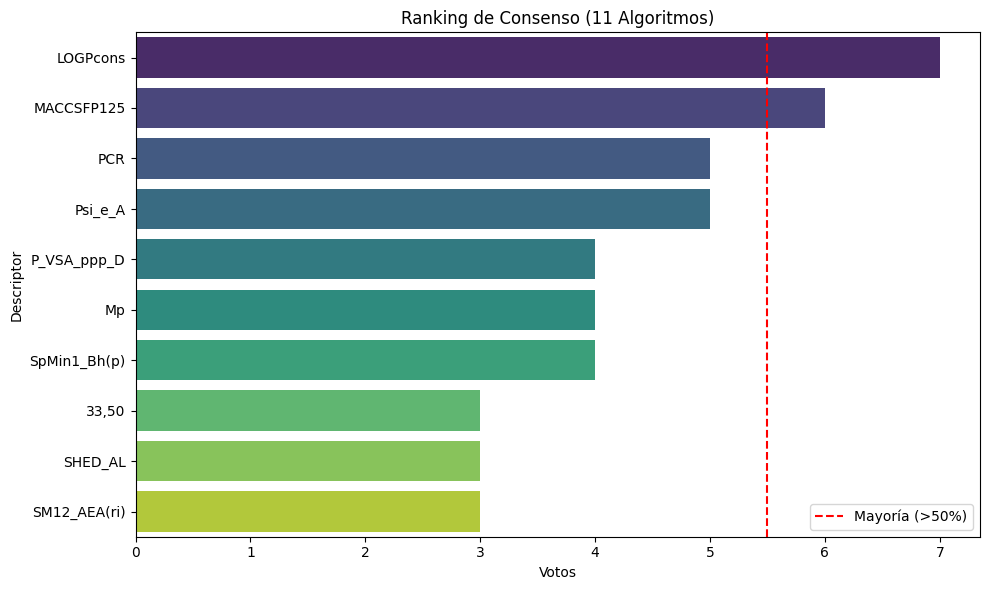

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Copia la ruta de los .log
RUTA_DE_TUS_LOGS = r"C:\Users\benja\Desktop\QSAR/EDA" 

def buscar_ganadores_manual(carpeta_logs):
    print(f"Analizando logs en: {os.path.abspath(carpeta_logs)}")
    
    if not os.path.exists(carpeta_logs):
        print("ERROR: La ruta especificada no existe. Verifica que la copiaste bien.")
        return

    conteo = {}
    total_modelos = 0
    archivos_encontrados = 0
    
    # Busca archivos .log
    for archivo in os.listdir(carpeta_logs):
        if archivo.endswith(".log"):
            archivos_encontrados += 1
            ruta = os.path.join(carpeta_logs, archivo)
            
            try:
                with open(ruta, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    
                    # Dividimos por ejecuciones
                    bloques = content.split("Selected attributes:")
                    
                    if len(bloques) > 1:
                        for bloque in bloques[1:]:
                            total_modelos += 1
                            lines = bloque.strip().split('\n')
                            
                            for line in lines:
                                line = line.strip()
                                # Criterios de parada
                                if not line or "Merit" in line or "===" in line:
                                    break
                                
                                parts = line.split()
                                for part in parts:
                                    # Limpieza
                                    if part.isdigit() or part in [":", "+", "attributes", "Selected", "null"]:
                                        continue
                                    # Guardar variable
                                    conteo[part] = conteo.get(part, 0) + 1
            except Exception as e:
                print(f"Error leyendo {archivo}: {e}")

    if total_modelos == 0:
        print(f"Se encontraron {archivos_encontrados} archivos .log, pero ninguno tenía resultados válidos.")
        return

    # --- RESULTADOS ---
    df = pd.DataFrame(list(conteo.items()), columns=['Descriptor', 'Votos'])
    df = df.sort_values('Votos', ascending=False)
    df['Frecuencia (%)'] = (df['Votos'] / total_modelos) * 100
    
    print(f" ANÁLISIS COMPLETADO: {total_modelos} modelos evaluados.")
    print(" --- TOP DESCRIPTORES (CONSENSO) ---")
    print(df.head(15).to_string(index=False))
    
    # Guardar en CSV
    archivo_salida = os.path.join(carpeta_logs, "Ranking_Final_Consenso.csv")
    df.to_csv(archivo_salida, index=False)
    print(f"\n💾 Ranking guardado en: {archivo_salida}")

    # Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Votos', y='Descriptor', data=df.head(10), 
                hue='Descriptor', legend=False, palette='viridis')
    plt.title(f'Ranking de Consenso ({total_modelos} Algoritmos)')
    plt.axvline(total_modelos/2, color='red', linestyle='--', label='Mayoría (>50%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejecutar
buscar_ganadores_manual(RUTA_DE_TUS_LOGS)

## Generacion de Base de datos solo con variables seleccionadas

In [ ]:
import pandas as pd
import os
# Asegúrate de que los nombres sean idénticos a como salen en tu CSV
cols_finales = [
    'LOGPcons', 
    'MACCSFP125', 
    'PCR', 
    'Psi_e_A', 
    'P_VSA_ppp_D', 
    'Mp', 
    'SpMin1_Bh(p)', 
    'SHED_AL' ,
    'SM12_AEA(ri)' , 
    'P_VSA_s_3' , 
    'MATS5m' ,
    'Actividad' 
]

print(" Generando archivos definitivos para Weka...")

# Ajusta la ruta si no están en la misma carpeta
try:
    df_train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR/EDA/training_final.csv")
    df_test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR/EDA/test_final.csv")
    df_ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR/EDA/external_final.csv")
    
    # Filtrar columnas
    df_train_ready = df_train[cols_finales]
    df_test_ready = df_test[cols_finales]
    df_ext_ready = df_ext[cols_finales]

    # Guardar
    df_train_ready.to_csv("FINAL_Training.csv", index=False)
    df_test_ready.to_csv("FINAL_Test.csv", index=False)
    df_ext_ready.to_csv("FINAL_External.csv", index=False)

    print("¡Archivos generados con éxito!")
    print("1. FINAL_Training.csv")
    print("2. FINAL_Test.csv")
    print("3. FINAL_External.csv")

except KeyError as e:
    print(f"ERROR: No encontré la columna {e}. Verifica el nombre exacto en tus CSVs.")
except FileNotFoundError as e:
    print(f" ERROR: No encontré el archivo {e}.")

🚀 Generando archivos definitivos para Weka...
¡Archivos generados con éxito!
1. FINAL_Training.csv
2. FINAL_Test.csv
3. FINAL_External.csv


## Transformacion a ARFF para usar en WEKA

In [6]:
import pandas as pd

# CONFIGURACIÓN
# Asegúrate de que estos nombres coincidan con tus archivos actuales
train_file = r"C:\Users\benja\Desktop\FINAL_Training.csv"
test_file = r"C:\Users\benja\Desktop\FINAL_Test.csv"
ext_file = r"C:\Users\benja\Desktop\FINAL_External.csv"

# Definir el nombre EXACTO de la columna clase y sus valores posibles
# IMPORTANTE: Revisa tus CSV. Si usas 'Act1' y 'Act-1', ponlos aquí en orden.
CLASS_COL = "Actividad" 
CLASS_VALUES = ["Act-1", "Act1"] # O el orden que prefieras, pero fijo para todos.

def write_arff(df, filename, relation_name):
    with open(filename, 'w') as f:
        f.write(f"@RELATION {relation_name}\n\n")
        
        # Escribir atributos
        for col in df.columns:
            if col == CLASS_COL:
                # Definir la clase como NOMINAL explícitamente con los mismos valores
                vals = ",".join(CLASS_VALUES)
                f.write(f"@ATTRIBUTE {col} {{{vals}}}\n")
            else:
                # El resto son numéricos
                f.write(f"@ATTRIBUTE {col} NUMERIC\n")
        
        f.write("\n@DATA\n")
        
        # Escribir datos
        for index, row in df.iterrows():
            line = []
            for col in df.columns:
                val = row[col]
                if col == CLASS_COL:
                    line.append(str(val))
                else:
                    # Asegurar formato numérico
                    line.append(str(val))
            f.write(",".join(line) + "\n")
            
    print(f"✅ Generado: {filename}")

# --- PROCESO ---
print("Cargando y homogeneizando archivos...")
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)
df_ext = pd.read_csv(ext_file)

# Asegurar orden de columnas idéntico al de Train
cols = df_train.columns.tolist()
df_test = df_test[cols]
df_ext = df_ext[cols]

# Generar ARFFs
write_arff(df_train, "WEKA_Train.arff", "Pampa_Data")
write_arff(df_test, "WEKA_Test.arff",   "Pampa_Data") # Misma relation name
write_arff(df_ext, "WEKA_Ext.arff",     "Pampa_Data") # Misma relation name

print("\nLISTO. Usa estos archivos .arff en Weka. ¡No fallarán!")

Cargando y homogeneizando archivos...
✅ Generado: WEKA_Train.arff
✅ Generado: WEKA_Test.arff
✅ Generado: WEKA_Ext.arff

LISTO. Usa estos archivos .arff en Weka. ¡No fallarán!
